In [1]:
import time

start = time.time()

# libraries to analyze data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

end = time.time()
print('Loading libraries takes %.4fs' % (end-start))

Loading libraries takes 1.3423s


# 1. Reading training and testing features

In [2]:
path_data = '../data/' # path to the data
path_submission = '../submission/' # path to submission files

In [3]:
start = time.time()

# ====== read training features ====== #
orig_training_features = np.genfromtxt(path_data + 'training_features.csv', delimiter=',', skip_header=1, dtype=float)

end = time.time()
print('Reading training features takes %.4f s' % (end-start))

Reading training features takes 13.9141 s


In [4]:
start = time.time()

# ====== read testing features as str ====== #
orig_testing_features = np.genfromtxt(path_data + 'testing_features.csv', delimiter=',', skip_header=1, dtype=float)

end = time.time()
print('Reading testing features takes %.4f s' % (end-start))

Reading testing features takes 0.6818 s


In [5]:
start = time.time()

# ====== read training data as str ====== #
training = np.genfromtxt(path_data + 'training_set.txt', dtype=str)

# ====== extract labels ====== #
labels = training[:, 2].astype(int) # get the labels

end = time.time()
print('Reading training set & extracting labels takes %.4f s' % (end-start))

Reading training set & extracting labels takes 3.2537 s


In [6]:
print('Training features:', orig_training_features.shape)
print('Labels:', labels.shape)
print('Testing features:', orig_testing_features.shape)

Training features: (615512, 18)
Labels: (615512,)
Testing features: (32648, 18)


# 2. Analysis

## 2.2 - Filtering out features

In [11]:
# list of selected features
orig_features = [
    'common_neighbors', # 0
    'jaccard', # 1
    'adamic_adar', # 2
    'in_kcore', # 3
    'katz_centrality', # 4
    'katz_linkpred', # 5
    'max_degrees', # 6
    'max_betweenness', # 7
    'max_pagerank', # 8
    'pref_attach', # 9
    'res_alloc', # 10
    'cos_tfidf', # 11
    'cos_w2v', # 12
    'cos_d2v', # 13
    'overlap_title', # 14
    'common_authors', # 15
    'temporal_diff', # 16
    'same_journal' # 17
]

In [12]:
# remove features
to_remove = []
training_features = np.delete(orig_training_features, to_remove, 1)
testing_features = np.delete(orig_testing_features, to_remove, 1)
features = np.delete(orig_features, to_remove)

print('Training features:', training_features.shape)
print('Testing features:', testing_features.shape)

Training features: (615512, 18)
Testing features: (32648, 18)


## 2.2 - Analysis

### 2.2.A) Correlation between features 

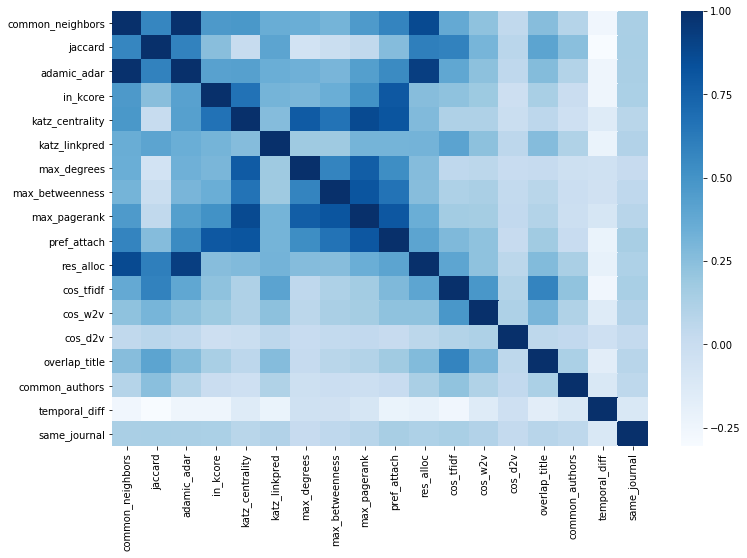

In [16]:
features_corr = np.corrcoef(training_features.T)
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(features_corr, xticklabels = features, yticklabels = features, cmap="Blues")

### 2.2.B) Feature distribution

In [17]:
pd_training_features = pd.DataFrame(training_features, columns=features)
pd_testing_features = pd.DataFrame(testing_features, columns=features)

In [18]:
pd_training_features.describe()

,common_neighbors,jaccard,adamic_adar,in_kcore,katz_centrality,katz_linkpred,max_degrees,max_betweenness,max_pagerank,pref_attach,res_alloc,cos_tfidf,cos_w2v,cos_d2v,overlap_title,common_authors,temporal_diff,same_journal
count,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000
mean,6.232439,0.058430,1.513243,0.564058,-4.878242,-10.194137,106.540634,11.460148,-9.654508,6.442046,0.125324,0.114068,0.691312,0.482368,0.495181,0.083410,2.795242,0.110368
std,11.137400,0.090385,2.740174,0.419826,0.684830,7.904377,239.809786,2.127001,0.869284,2.200320,0.247067,0.116394,0.097221,0.192883,0.862290,0.357317,2.434508,0.313348
min,0.000000,0.000000,0.000000,0.000000,-5.687178,-26.491587,0.000000,-2.197225,-12.126196,0.000000,0.000000,0.000000,0.000000,-0.563367,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-5.423421,-18.181418,21.000000,10.376061,-10.221167,4.905275,0.000000,0.027508,0.632570,0.370782,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.011905,0.345976,0.500000,-5.008226,-5.278342,44.000000,11.492155,-9.807633,6.530878,0.018519,0.072819,0.700879,0.513536,0.000000,0.000000,2.000000,0.000000
75%,9.000000,0.087156,2.191180,1.000000,-4.559881,-5.231551,91.000000,12.563473,-9.272313,8.045588,0.180715,0.167300,0.760227,0.624468,1.000000,0.000000,4.000000,0.000000
max,1421.000000,0.880000,398.799149,1.000000,-1.897388,0.000000,2346.000000,17.968457,-6.085432,15.120571,44.127963,0.989114,1.000000,0.936418,9.000000,8.000000,11.000000,1.000000


In [19]:
pd_testing_features.describe()

,common_neighbors,jaccard,adamic_adar,in_kcore,katz_centrality,katz_linkpred,max_degrees,max_betweenness,max_pagerank,pref_attach,res_alloc,cos_tfidf,cos_w2v,cos_d2v,overlap_title,common_authors,temporal_diff,same_journal
count,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000,32648.000000
mean,6.159213,0.060706,1.498448,0.554766,-4.880698,-12.131125,107.563924,11.439569,-9.667390,6.378698,0.124805,0.113524,0.691073,0.483055,0.491393,0.082026,2.813741,0.109134
std,10.944711,0.096649,2.691890,0.418068,0.693057,7.009795,243.684146,2.155331,0.884438,2.223431,0.243233,0.116244,0.097266,0.193274,0.864580,0.350659,2.443407,0.311812
min,0.000000,0.000000,0.000000,0.000000,-5.687178,-26.491587,0.000000,-0.693147,-12.126196,0.000000,0.000000,0.000000,0.000000,-0.428678,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-5.434166,-18.475682,20.000000,10.330326,-10.233916,4.836282,0.000000,0.027414,0.631837,0.371515,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.010471,0.309090,0.500000,-5.016616,-9.281015,43.000000,11.471153,-9.827842,6.445720,0.014878,0.071519,0.701087,0.514177,0.000000,0.000000,2.000000,0.000000
75%,9.000000,0.089109,2.162677,1.000000,-4.562177,-7.986707,91.000000,12.552499,-9.281255,7.996317,0.178629,0.166028,0.760634,0.625025,1.000000,0.000000,4.000000,0.000000
max,398.000000,1.000000,110.394619,1.000000,-1.897388,0.000000,2346.000000,17.968457,-6.085432,13.981057,13.728687,0.951020,0.991017,0.926003,7.000000,5.000000,11.000000,1.000000
